In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

#SPARCS dataset exploration
Summary from https://health.data.ny.gov/api/views/3m9u-ws8e/files/36BsAxNLFSSox4N2_Sw9cG1BnJKJ4rCbUCS8qWDZKB0?download=true&filename=NYSDOH_HospitalInpatientDischarges_SPARCS_De-Identified_Intro_to_SPARCS.pdf :

>###What is SPARCS?

>- Statewide Planning and Research Cooperative System (SPARCS)
- Cooperation between the health care industry and government
- Been in existence over 30 years: established through statute in 1979
- Calendar Year Based Discharge/Visit Dataset
- *Claim level detail on patient characteristics, diagnoses and treatments, services, and charges for hospital discharges, ambulatory surgery, emergency department, and hospital based outpatient service visits (or EODC) in New York State*


There's an overview of the project available here https://www.health.ny.gov/statistics/sparcs/ . 
Researchers can apply for multiple levels of access to this data, with the most restricted file containing individually identifiable elements such as SSN and dates of birth for patients. 

The file I am exploring here is the least-restricted version, containing summary-level details per patient stay at a hospital inpatient facility in 2012. This level of file for years 2009-2013 are available here: https://health.data.ny.gov/en/browse?q=sparcs+inpatient+downloadable

In [41]:
# File has been downloaded already. It is roughly 1GB in size, with about 2,500,000 rows. 
dataURI = 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2012.csv'
csv = pd.read_csv(dataURI)

In [52]:
csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2529422 entries, 0 to 2529421
Data columns (total 38 columns):
Health Service Area                    object
Hospital County                        object
Operating Certificate Number           float64
Facility Id                            float64
Facility Name                          object
Age Group                              object
Zip Code - 3 digits                    object
Gender                                 object
Race                                   object
Ethnicity                              object
Length of Stay                         object
Admit Day of Week                      object
Type of Admission                      object
Patient Disposition                    object
Discharge Year                         int64
Discharge Day of Week                  object
CCS Diagnosis Code                     int64
CCS Diagnosis Description              object
CCS Procedure Code                     int64
CCS Procedure 

In [53]:
# 3 sample rows:
csv.head(3).transpose()

,0,1,2
Health Service Area,Capital/Adiron,Capital/Adiron,Capital/Adiron
Hospital County,Albany,Albany,Albany
Operating Certificate Number,101000,101000,101000
Facility Id,1,1,1
Facility Name,Albany Medical Center Hospital,Albany Medical Center Hospital,Albany Medical Center Hospital
Age Group,50 to 69,30 to 49,70 or Older
Zip Code - 3 digits,120,121,120
Gender,M,F,M
Race,White,Other Race,White
Ethnicity,Not Span/Hispanic,Not Span/Hispanic,Not Span/Hispanic


##Cleaning the data: 

- "Zip Code - 3 digits" should have the full 6 digits if we're going to use it for anything. 
- These fields seem irrelevant for our purposes, we should drop: 
    - Birth Weight
    - Abortion Edit Indicator
    - Other Provider License Number
    - operating certificate number
- rows with procedure codes of zero are going to prevent us from including those rows in our group by procedure code below (our least granular means of comparing costs), let's drop those as well. 
- "Total Charges" is a string with a dollar sign at the front, not particularly useful for performing any operations on it. 



In [82]:
# Drop columns we don't need
data = csv.drop(["Birth Weight", "Abortion Edit Indicator", "Other Provider License Number", "Operating Certificate Number"], axis=1)

In [55]:
# TODO: remap zipcodes with a 100 in front, get rid of non-zipcodelike values
# data["Zip Code - 3 digits"] = data["Zip Code - 3 digits"].astype(int)
# data["Zip Code - 3 digits"] += 10000

In [83]:
# Convert strings to float values, strip out the dollar signs
data['Total Charges'] = [float(i.strip('$')) for i in data['Total Charges'].values]

In [84]:
print "number of unique CCS procedure codes: " + str(len(pd.unique(csv['CCS Procedure Code'])))
print "number of unique APR-DMG procedure codes: " + str(len(pd.unique(csv['APR DRG Code'])))

number of unique CCS procedure codes: 231
number of unique APR-DMG procedure codes: 316


In [207]:
# do we have procedure codes for every line? 
grouped = csv.groupby('CCS Procedure Code')
size = grouped.size()
print "Number of lines with a procedure code: "
print size.sum()

Number of lines with a procedure code: 
2529422


In [86]:
# What is a procedure code of "0"? There seem to be a lot of those. 
# According to the Utah DOH, a procedure code of 0 indicates 'no procedure'. 
# http://health.utah.gov/opha/IBIShelp/codes/CCS.htm That's not very helpful, let's drop those. 

print len(data)
rows = data[data['CCS Procedure Code'] == 0].index
data.drop(rows, inplace=True)
print len(data)

2529422
1902459


## Now that things have been cleaned up a little...
What's our thesis here?
We think that costs vary wildly for the same procedure at different hospitals, based on a variety of factors. Maybe some doctors are more expensive. Maybe some hospitals negotiate higher fees. Maybe some hospitals use Kleenex brand tissues and maybe some use generics. Is this the case? 

Let's plot a histogram of cost values for CCS procedure code 80 (an Appendectomy), and look at the distribution.  

count      18075.000000
mean       23322.762975
std        22192.666539
min            1.000000
25%        13679.010000
50%        19435.500000
75%        27119.890000
max      1070905.760000
dtype: float64

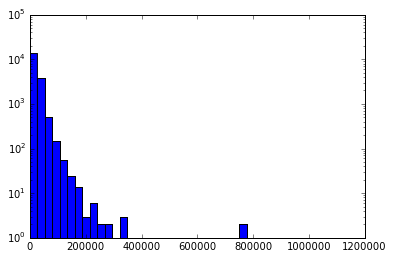

In [91]:
appendectomies = data[data['CCS Procedure Code'] == 80]['Total Charges']
plt.hist(appendectomies.values, bins=40, log=True)
pd.Series(appendectomies.values).describe()

This distribution is pretty wide for an appendectomy. It seems odd that many appendectomies could cost ~$780,000. 
I wonder if maybe we should be grouping by the APR-DRG, which is essentially a severity + a slightly expanded list of procedures (documentation here: https://www.bcbst.com/providers/webinar/APRDRG.pdf) So we could get a distribution of appendectomies with various severity levels, for instance. Perhaps that will show less variance. 

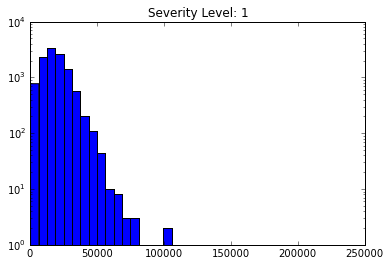

count     11539.000000
mean      18843.534123
std        9505.264808
min         463.830000
25%       12443.040000
50%       17841.310000
75%       23805.265000
max      248591.030000
dtype: float64


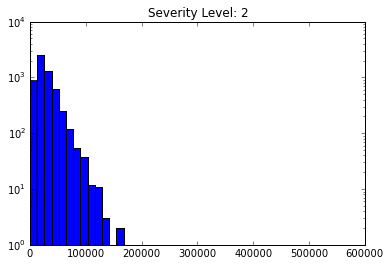

count      5796.000000
mean      27636.694196
std       19072.205245
min           1.000000
25%       15790.137500
50%       23050.455000
75%       34027.792500
max      516782.800000
dtype: float64


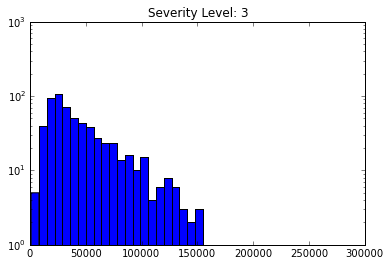

count       615.000000
mean      46407.442390
std       33661.011202
min        1065.320000
25%       22693.400000
50%       35386.200000
75%       61106.395000
max      280962.750000
dtype: float64


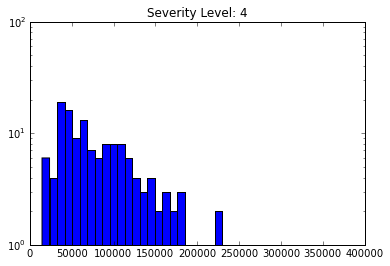

count       139.000000
mean      87474.731079
std       57634.592490
min       14454.100000
25%       44305.800000
50%       70187.100000
75%      112059.080000
max      373070.410000
dtype: float64


In [92]:
severity_levels = range(1,5)

for l in severity_levels:
    APR_appendectomies = data[(data['APR DRG Code'] == 225) & (data['APR Severity of Illness Code'] == l)]['Total Charges']
    plotlabel = "Severity Level: " + str(l)
    plt.hist(APR_appendectomies.values, bins=40, log=True)
    plt.title(plotlabel)
    ap = pd.Series(APR_appendectomies.values)
    plt.show()
    print ap.describe()

#Outlier Removal:
I'm going to (crudely) eliminate observations with a cost over $200000, these are clearly outliers. Let's plot the results.  

In [195]:
print len(data)
rows = data[(data['APR DRG Code'] == 225) & (data['Total Charges'] > 200000)].index
data.drop(rows, inplace=True)
print len(data)

1902459
1902449


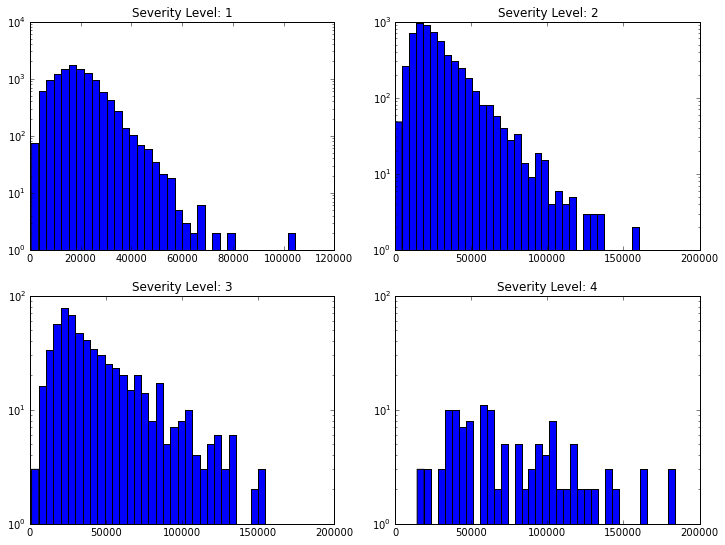

In [206]:
plt.close()
f, axarr = plt.subplots(2, 2, figsize=(12,9))
i = 1
for ax in axarr.flat: 
    APR_appendectomies = data[(data['APR DRG Code'] == 225) & (data['APR Severity of Illness Code'] == i)]['Total Charges']
    plotlabel = "Severity Level: " + str(i)
    ax.hist(APR_appendectomies.values, bins=40, log=True)
    ax.set_title(plotlabel)
    i +=1
plt.show()
# box and whisker or violin plot? 
# explore cost by payer!

#Analysis of Variance

So this seems to be a good basis for grouping these visits, the APR-DRG has a narrower spread, and looks like it should be easier to eliminate outliers. Let's look at the variance between hospitals for appendectomy costs, as well as the variance between the individual cases in each hospital. 

In [66]:
print "Unique APR codes: " + str(len(pd.unique(csv['APR DRG Code'])))
print "Unique hospitals: " + str(len(pd.unique(csv['Facility Id'])))

Unique APR codes: 316
Unique hospitals: 224


In [159]:
# TODO - we want to see the variance between charges for a given procedure within a hospital, and the variance between mean charges for a procedure between hospitals
# intra_hospital_variances = data.groupby(['Facility Id', 'APR DRG Code'])['Total Charges'].var()
# inter_hospital_variance = data.groupby(['Facility Id','APR DRG Code'])['Total Charges'].mean().var()
charges_by_fac = data[data['APR DRG Code'] == 225].groupby('Facility Id')['Total Charges']
inter_hospital_variance = data.groupby(['Facility Id','APR DRG Code'])['Total Charges'].mean().var()


In [224]:
# Doublecheck variance calcs. 

facilitylist = data['Facility Id'].unique()
var_dict = {}
means_dict = {}
deviations = []
for i in facilitylist:
    charges = data[(data['APR DRG Code'] == 225) & (data['Facility Id'] == i)]['Total Charges']
    if len(charges) != 0:
        var_dict[i] = charges 
        means_dict[i] = charges.mean()
    else: 
        continue
    
#     print "facility " + str(i) + " number of appendectomies: " + str(len(var_dict[i]))
#     print "facility " + str(i) + " deviation of appendectomy costs " + str(var_dict[i].std())
    deviations.append(var_dict[i].std())
    
    
# print "deviation of mean charges per facility: " + str(pd.Series(means_dict.values()).std())

AssertionError: incompatible sizes: argument 'height' must be length 1 or scalar

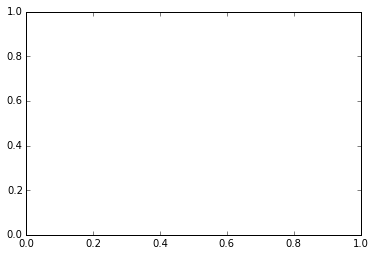

In [231]:
deviations = [x for x in deviations if x != 'na']
plt.bar(len(deviations), deviations)

In [139]:
facs = data.groupby('Facility Id').size()
facs

Facility Id
1              21538
2                 29
4               1981
5              20291
37                20
39               943
42              2619
43              6054
58             10204
66              3114
85              2747
98              1939
102             1353
103             5434
111                9
...
1637           31511
1638           11209
1639            4848
1692           10451
1737            6957
1738            9938
1740           25907
3058           23763
3067           11244
3297            1681
3376           11809
3975            9593
5785             274
9059             507
9250            2134
Length: 216, dtype: int64

In [ ]:
# TODO: 
# plot the highest cost procedures, lowest cost procedures
# highest cost zipcodes, lowest cost zipcodes, deviations - plot on map
# highest cost hospitals, lowest cost hospitals, deviations
# highest cost providers, lowest cost hospitals, deviations

(array([ 3.,  8.,  2.,  7.,  6.,  9.,  6.,  8.,  8.,  3.,  4.,  2.,  5.,
         3.,  2.,  3.,  4.,  1.,  2.,  6.,  1.,  6.,  3.,  5.,  2.,  3.,
         2.,  0.,  3.,  1.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  4.,  3.,  1.,  3.,  3.,  0.,  3.,  3.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  1.]),
 array([  3.87376088e

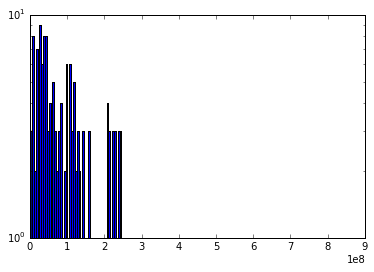

In [193]:
# print "new variance intra-hospital"
# for index, val in charges_by_fac.var().iteritems(): 
#     print str(val)

# print "variance inter-hospital"
# print charges_by_fac.mean().var()
# print "mean intra-hospital variance grouped by DRG " + intra_hospital_variances.mean().astype(str)
# print "inter-hospital variance " + inter_hospital_variance.astype(str)
var = charges_by_fac.var().values[~np.isnan(var)]
plt.hist(var, bins = len(var)+1, log=True)